## Import your stuff

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pydelfi import delfi
from pydelfi import ndes

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
from simulators.jla_supernovae import jla_simulator as jla

JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/charnock/Physics/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5]).astype(np.float32)
upper = np.array([0.6, 0, -18, 1, 6, 0.5]).astype(np.float32)
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(lower.shape[0])])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
from pydelfi import score
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

For this example let's define a stack of 6 NDEs; one Masked Autoregressive Flow (MAF) and five Mixture Density Networks (MDNs) with 1-5 full-rank Gaussian components respectively

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6,
            n_mades=5,
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            all_layers=True)
        for i in range(3)]

NDEs += [ndes.MixtureDensityNetwork(
            n_parameters=6,
            n_data=6, 
            n_components=i+1,
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(3)]

W0401 15:01:22.138030 4594740672 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/linalg/linear_operator_lower_triangular.py:158: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv=Finv, 
                            theta_fiducial=theta_fiducial, 
                            param_names=['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir="simulators/jla_supernovae/results",
                            filename="jla",
                            optimiser=tf.keras.optimizers.Adam,
                            optimiser_arguments=None,
                            dtype=tf.float32,
                            posterior_chain_length=100,
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Training terminated for model 0 at epoch 38.
Training terminated for model 1 at epoch 38.
Training terminated for model 2 at epoch 45.
Training terminated for model 4 at epoch 203.
Training terminated for model 3 at epoch 296.


W0401 15:15:04.000375 4594740672 def_function.py:586] 5 out of the last 10 calls to <function NDE.log_prob at 0x144059b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 311.
Sampling approximate posterior...
Done.
Removed no burn in


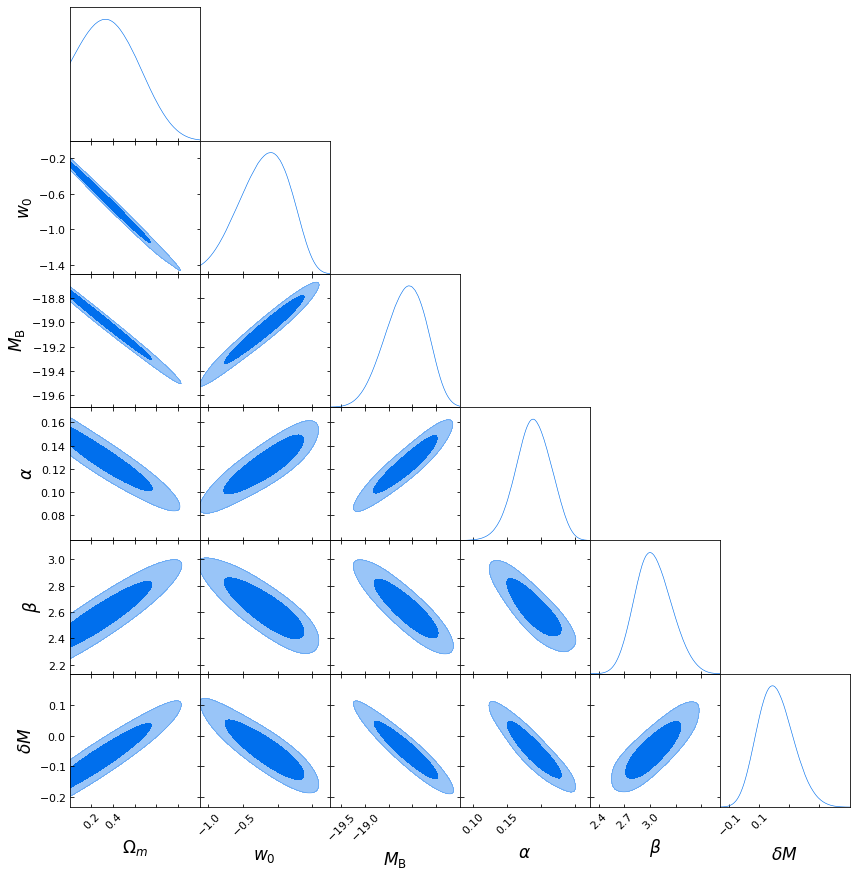

In [8]:
DelfiEnsemble.fisher_pretraining(n_batch=5000, epochs=1000, patience=15, plot=True)

## Sequential Neural Likelihood

Training terminated for model 4 at epoch 104.


W0401 15:30:05.540977 4594740672 def_function.py:586] 6 out of the last 12 calls to <function NDE.log_prob at 0x144059b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 3 at epoch 118.


W0401 15:31:39.974300 4594740672 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x144059b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 1 at epoch 158.
Training terminated for model 2 at epoch 158.


W0401 15:35:49.290647 4594740672 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x144059b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 0 at epoch 184.
Training terminated for model 5 at epoch 188.
Sampling approximate posterior...
Done.
Removed no burn in


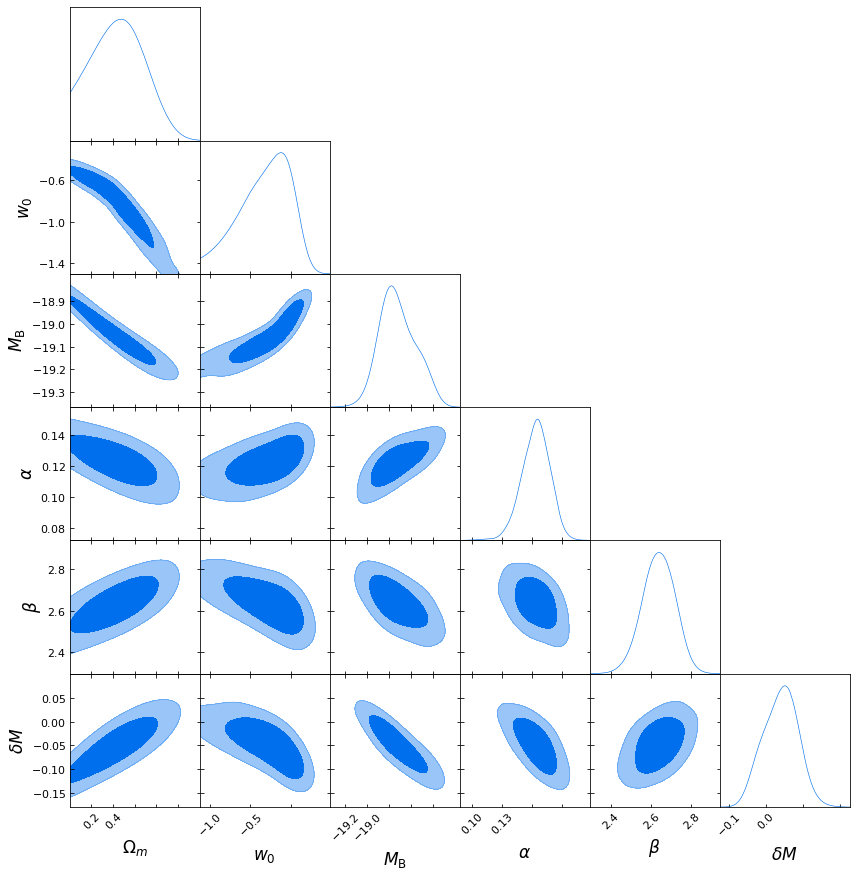

Population 1/10
Sampling proposal density...


In [ ]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, plot=True, save_intermediate_posteriors=True)

## Sample the learned posterior

In [ ]:
posterior_samples, posterior_weights, log_posterior_values = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [ ]:
x = 123456
float("{0:.3g}".format(x))

In [ ]:
x = np.random.normal(1200, 1, 5)
np.array2string(x, precision=2)

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:

n_batch= 5000
# Broader proposal
proposal = tfd.TruncatedMultivariateNormalTriL(
    loc=DelfiEnsemble.theta_fiducial, scale_tril=tf.linalg.cholesky(9*DelfiEnsemble.Finv),
    low=DelfiEnsemble.prior.low, high=DelfiEnsemble.prior.high,
    validate_args=False, allow_nan_stats=True,
    name='AsymptoticPosterior')

# Cholesky of inverse Fisher information matrix
L = np.linalg.cholesky(DelfiEnsemble.Finv)

# Sample parameters from some broad proposal
theta_batch = np.zeros((3*n_batch, DelfiEnsemble.npar))
theta_batch[:n_batch,:] = DelfiEnsemble.prior.sample(n_batch)
theta_batch[n_batch:2*n_batch,:] = DelfiEnsemble.asymptotic_posterior.sample(n_batch)
theta_batch[2*n_batch:,:] = proposal.sample(n_batch)

# Sample data assuming a Gaussian likelihood
data_batch = np.array([theta + np.dot(L, np.random.normal(0, 1, DelfiEnsemble.npar)) for theta in theta_batch], dtype=np.float32)

# Construct the initial training-set
fisher_theta_train = (theta_batch.astype(np.float32).reshape((3*n_batch, DelfiEnsemble.npar)) - DelfiEnsemble.theta_shift)/DelfiEnsemble.theta_scale
fisher_data_train = (data_batch.astype(np.float32).reshape((3*n_batch, DelfiEnsemble.npar)) - DelfiEnsemble.data_shift)/DelfiEnsemble.data_scale


In [ ]:
fisher_theta_train.shape

In [ ]:
import matplotlib.pyplot as plt
plt.hist(fisher_data_train[:,-1], bins=80)
plt.show()

In [ ]:
x = DelfiEnsemble.asymptotic_posterior.sample(10000)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(x[:,1], bins=80)
plt.show()

In [ ]:
DelfiEnsemble.posterior_samples.shape

In [ ]:
samples, weights, log_prob = DelfiEnsemble.emcee_sample()

In [ ]:
samples.shape

In [ ]:
DelfiEnsemble.prior.log_prob(theta_fiducial.astype(np.float32))

In [ ]:
DelfiEnsemble.NDEs.weighted_log_prob((compressed_data.astype(np.float32) - DelfiEnsemble.data_shift)/DelfiEnsemble.data_scale, conditional=(theta_fiducial.astype(np.float32) - DelfiEnsemble.theta_shift)/DelfiEnsemble.theta_scale)

In [ ]:
NDEs[0].log_prob(tf.convert_to_tensor((compressed_data - theta_fiducial)/DelfiEnsemble.fisher_errors, dtype=tf.float32), conditional=tf.convert_to_tensor((compressed_data - theta_fiducial)/DelfiEnsemble.fisher_errors, dtype=tf.float32))